# Sea Surface Temperature Reconstruction under cloud occlusion

Sea Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

#import gdown

The next cells contain instructions for downloading data.
**Please, make your own copy.**

In [2]:
# Verifica se ci sono GPU disponibili
gpus = tf.config.list_physical_devices('GPU')
assert gpus, "GPU non disponibile"

# Verifica se TensorFlow è stato costruito con il supporto CUDA
assert tf.test.is_built_with_cuda(), "TensorFlow non è stato costruito con il supporto CUDA"

print("GPU disponibile e TensorFlow è stato costruito con il supporto CUDA")

GPU disponibile e TensorFlow è stato costruito con il supporto CUDA


In [3]:
tf.keras.backend.clear_session()

Le us inspect and visualize data.

In [3]:
x_train_n = np.load('/kaggle/input/sst-dataset/x_train_night.npy')
x_val_n = np.load('/kaggle/input/sst-dataset/x_val_night.npy')
x_test_n = np.load('/kaggle/input/sst-dataset/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

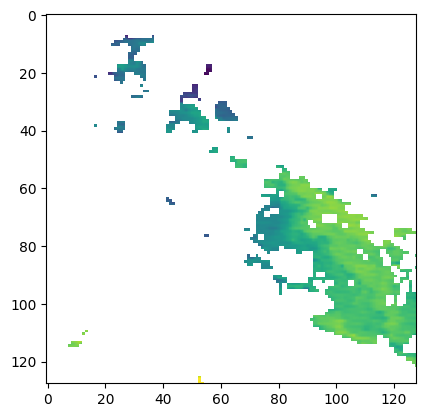

In [5]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [4]:
dates_train_n = np.load('/kaggle/input/sst-dataset/dates_train_night.npy')
dates_val_n = np.load('/kaggle/input/sst-dataset/dates_val_night.npy')
dates_test_n = np.load('/kaggle/input/sst-dataset/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


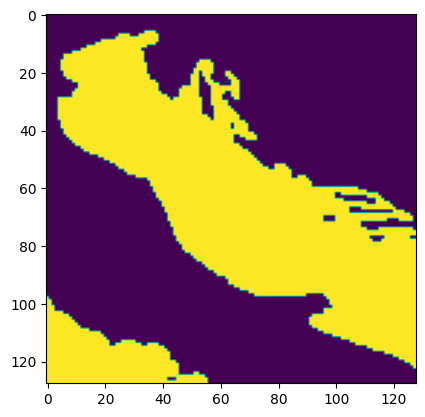

In [5]:
land_sea_mask = np.load('/kaggle/input/sst-dataset/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [6]:
baseline = np.load('/kaggle/input/sst-dataset/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


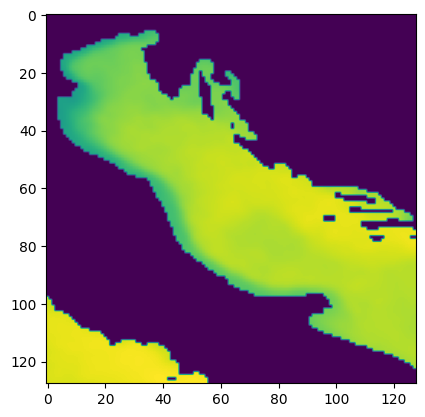

In [9]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [7]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [8]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [9]:
def generator_fn(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [10]:
batch_size = 32

train_gen = generator_fn(batch_size, x_train_n, dates_train_n)
val_gen = generator_fn(batch_size, x_val_n, dates_val_n)
test_gen = generator_fn(batch_size, x_test_n, dates_test_n)

In [11]:
batch_x, batch_y = next(train_gen)
print(batch_x.shape, batch_y.shape)

(32, 128, 128, 4) (32, 128, 128, 3)


The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [12]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 27.46999930371726
image 0; 0.0, 27.46999930371726
image 1; 0.0, 27.2950001094203
image 2; 0.0, 27.463520252304143


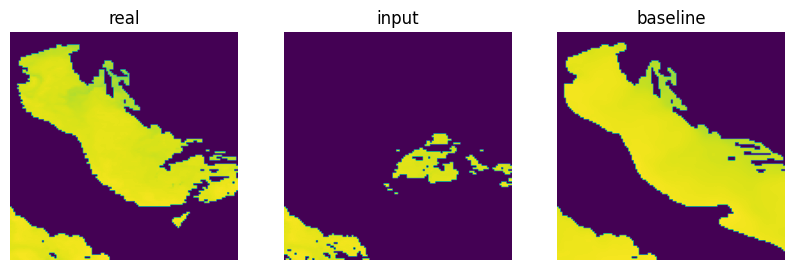

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


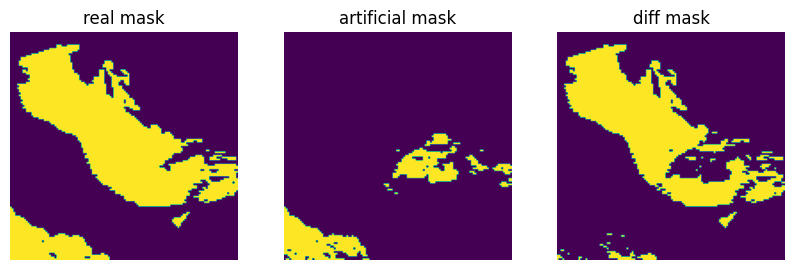

In [13]:
batch_x, batch_y = next(test_gen) #estrae i batch dal generatore di test e li salva in batch_x e batch_y
assert(np.sum(np.isnan(batch_x))==0) #verifica che il numero totale di nan in batch_x sia 0
assert(np.sum(np.isnan(batch_y))==0) #verifica che il numero totale di nan in batch_y sia 0
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0) #denormalizza i dati reali diversi da 0
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0) #denormalizza i dati artificiali diversi da 0
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0) #denormalizza i dati del baseline diversi da 0

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [14]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    #predictions = model.predict(x_true, verbose=0)
    predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))
print("Devo abbassare il più possibile questi due valori")

RMSE : 0.6313619933042244
RMSE std : 0.18298541678786437
Devo abbassare il più possibile questi due valori


In [15]:
print(RMSE)

[0.7807794  0.56990486 0.37089773 ... 0.63077747 0.52241817 0.5135389 ]


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.


# LETSGOSKY

In [16]:
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

## GAN Generator 

In [67]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(128, 128, 4))) # 128x128 image with 4 channel as input
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))

    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(negative_slope=0.2))

    model.add(layers.Conv2DTranspose(3, (3, 3), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 3)
    
    return model

## GAN DISCRIMINATOR 

In [68]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=[128, 128, 3]))
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    # Aggiungi più strati per aumentare la capacità del discriminatore
    model.add(layers.Conv2D(1024, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(negative_slope=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    # Add the classification layer with sigmoid activation
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

## TRAIN GAN

In [69]:
def train_gan(generator_gan, discriminator, generator_fn, dataset, dates, epochs=50, batch_size=32, generator_steps=2):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    def discriminator_loss(real_output, fake_output):
        real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
        fake_loss = cross_entropy(tf.zeros_like(fake_output) * 0.1, fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(fake_output):
        return tf.keras.losses.BinaryCrossentropy(from_logits=False)(tf.ones_like(fake_output), fake_output)

    generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

    data_generator = generator_fn(batch_size=batch_size, dataset=dataset, dates=dates)

    for epoch in range(epochs):
        batch_x, batch_y = next(data_generator)
        
        for _ in range(generator_steps):  # Train the generator multiple times before updating the discriminator
            with tf.GradientTape() as gen_tape:
                generated_images = generator_gan(batch_x, training=True) 
                
                # Freeze the discriminator while updating the generator
                discriminator.trainable = False
                fake_output = discriminator(generated_images, training=True)
                gen_loss = generator_loss(fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator_gan.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator_gan.trainable_variables))

        # Train the discriminator only once after generator steps
        generated_images = generator_gan(batch_x, training=False)  # Using artificially clouded image

        with tf.GradientTape() as disc_tape:
            discriminator.trainable = True  # Unfreeze the discriminator for training
            real_output = discriminator(batch_y, training=True)  # Real SST images
            fake_output = discriminator(generated_images, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1}, Gen Loss: {gen_loss}, Discr Loss: {disc_loss}")


In [70]:
# Compila i modelli
generator_gan = make_generator_model()
discriminator = make_discriminator_model()

In [83]:
tf.keras.backend.clear_session()

In [84]:
# Addestra la DCGAN
train_gan(generator_gan, discriminator, generator_fn, x_train_n, dates_train_n, epochs=500, batch_size=32)

Epoch 10, Gen Loss: 0.7048707008361816, Discr Loss: 1.3732367753982544
Epoch 20, Gen Loss: 0.6783139109611511, Discr Loss: 1.3779208660125732
Epoch 30, Gen Loss: 0.6695574522018433, Discr Loss: 1.387587308883667
Epoch 40, Gen Loss: 0.732224702835083, Discr Loss: 1.4000484943389893
Epoch 50, Gen Loss: 0.778436541557312, Discr Loss: 1.4013495445251465
Epoch 60, Gen Loss: 0.7640174031257629, Discr Loss: 1.4059779644012451
Epoch 70, Gen Loss: 0.7296594381332397, Discr Loss: 1.4040579795837402
Epoch 80, Gen Loss: 0.7208179831504822, Discr Loss: 1.4053986072540283
Epoch 90, Gen Loss: 0.7299842834472656, Discr Loss: 1.3972300291061401
Epoch 100, Gen Loss: 0.7511821389198303, Discr Loss: 1.3965637683868408
Epoch 110, Gen Loss: 0.7283157110214233, Discr Loss: 1.3917993307113647
Epoch 120, Gen Loss: 0.6883951425552368, Discr Loss: 1.376908302307129
Epoch 130, Gen Loss: 0.6421757936477661, Discr Loss: 1.3794958591461182
Epoch 140, Gen Loss: 0.6001724600791931, Discr Loss: 1.3836019039154053
Epoch

In [92]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)

    predictions = generator_gan(batch_x, training=False)

    # Denormalize data !!!
    predictions_denorm = predictions * x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0] * x_train_std + x_train_mean

    # Riduci predictions_denorm per adattarlo a true_values_denorm
    #predictions_denorm_reduced = tf.reduce_mean(predictions_denorm, axis=-1)

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2, axis=(1, 2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))
print("Devo abbassare il più possibile questi due valori")

RMSE : 3.8972101
RMSE std : 2.2558413
Devo abbassare il più possibile questi due valori


In [93]:
print(RMSE)

[1.894583  2.3016777 4.2963934 ... 7.1131086 2.1713376 2.9425712]
